In [165]:
import requests, json, time
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False

headers = {'X-Api-Key':'Ensert your key here'}
# 
def get_traffic_snapshot(t = "2021-06-25 12:00:00Z", contents = "full", area = "-6.2603,53.3498,30"):
    time.sleep(.2)
    data = json.loads(
        '{ "time":"'+t+'", "contents":"'+contents+'", "area":"'+area+'"}'
    )
    for i in range(10):
        r = requests.post('https://telraam-api.net/v1/reports/traffic_snapshot', headers=headers, data=json.dumps(data))
        if r.ok:
            return r
        else:
            time.sleep(5)

In [21]:
from datetime import datetime
# Get a sample of points each day over one year
samplepoints = [d.strftime("%Y-%m-%d 11:00:00Z") for d in pd.date_range(end = datetime.utcnow(), periods = 365).to_pydatetime().tolist()]

In [22]:
# Read data for each sample point
dl = [get_traffic_snapshot(t=t, area = "-6.2603,53.3498,3") for t in samplepoints]

In [23]:
# Filter outn unsuccessful requests
dl_filtered = list(filter(lambda x: 'features' in x.json(), dl))

In [25]:
#Check how many unsuccessful requests occurred
len(dl), len(dl_filtered)

(365, 365)

In [111]:
# Enter data to pandas dataframe
dublinData = pd.concat([pd.json_normalize(json.loads(l.content), record_path = ['features']) for l in dl_filtered])

In [112]:
# Cleaning data

#convert v85 to float
dublinData['v85'] = pd.to_numeric(dublinData['properties.v85'])

#calculate proportion of pedestrian
dublinData['prop'] = dublinData['properties.pedestrian']*100 / ( dublinData['properties.pedestrian'] + dublinData['properties.heavy'] + dublinData['properties.car'] + dublinData['properties.bike'])
dublinData['v85_bins'] = pd.cut(dublinData['v85'], bins=[0,20,25,30,35,40,45,50,70])
dublinData['total_count'] =  dublinData['properties.pedestrian'] + dublinData['properties.heavy'] + dublinData['properties.car'] + dublinData['properties.bike']

C:\Users\ColinBoyle\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_count', ylabel='Density'>

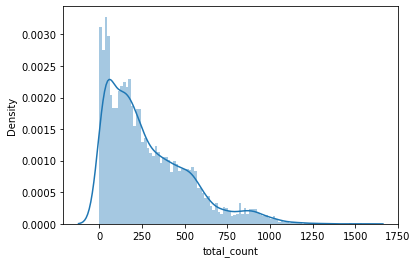

In [113]:
sns.distplot(dublinData['total_count'],bins=100)

In [114]:
dublinData = dublinData [ (dublinData['properties.uptime']>.1) & (dublinData['properties.car']>0)
           #& (dublinData['properties.heavy']>0)
           #& (dublinData['properties.bike']>0)
           & (dublinData['properties.pedestrian']>0) # remove cameras in which a category shows no counts
           & (dublinData['properties.segment_id']!=9000001485)  # Remove Temple Bar (pedestrianised)
           & (dublinData['total_count']>100)].dropna()
            

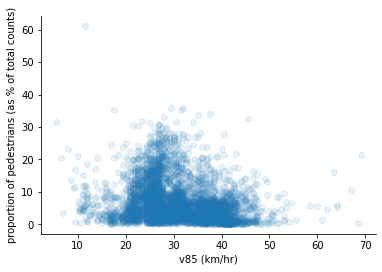

In [115]:
# Plot the raw data
import matplotlib.pyplot as plt
plt.scatter(dublinData['v85'],dublinData['prop'],alpha=0.1)
sns.despine()
plt.gca().set_xlabel('v85 (km/hr)')
plt.gca().set_ylabel('proportion of pedestrians (as % of total counts)')
plt.savefig('raw data.svg')

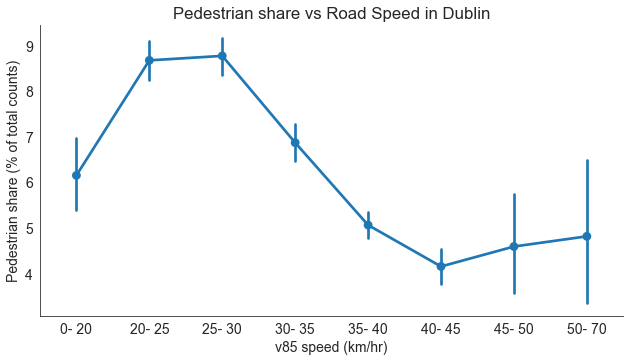

In [169]:
import seaborn as sns
sns.set_style('white')
g = sns.catplot(data=dublinData, x='v85_bins', y='prop', kind='point')

ax = g.axes[0][0]

ax.set_xticklabels([label.get_text()[1:-1].replace(',','-') for label in ax.get_xticklabels()])

ax.set_ylabel('Pedestrian share (% of total counts)')
ax.set_xlabel('v85 speed (km/hr)')
ax.set_title('Pedestrian share vs Road Speed in Dublin')

plt.gcf().set_size_inches(10,5)

plt.savefig('Pedestrian share vs road speed dublin.svg')

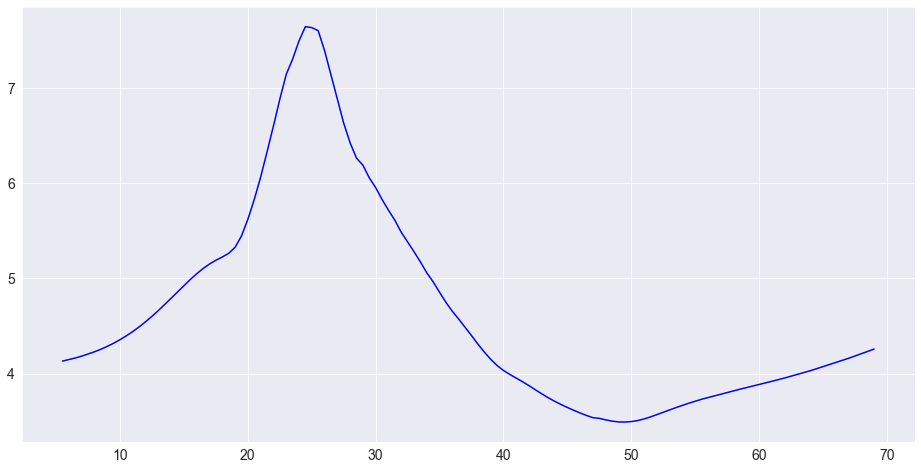

In [164]:
import statsmodels.api as sm

y_lowess = sm.nonparametric.lowess(dublinData['prop'], dublinData['v85'], frac = 0.4)  # 30 % lowess smoothing

plt.plot(y_lowess[:, 0], y_lowess[:, 1], 'b')  # some noise removed
plt.show()

In [143]:
# Use lowess smoothing to extract continuous relationship between v85 and pedestrian count
d = dublinData.sample(frac=1).sort_values(by='v85')

import numpy as np
import pylab
import seaborn as sns
import statsmodels.api as sm
sns.set_style("darkgrid")
pylab.rc("figure", figsize=(16, 8))
pylab.rc("font", size=14)

smoothed = sm.nonparametric.lowess(exog=d['v85'], endog=d['prop'], frac=0.2)

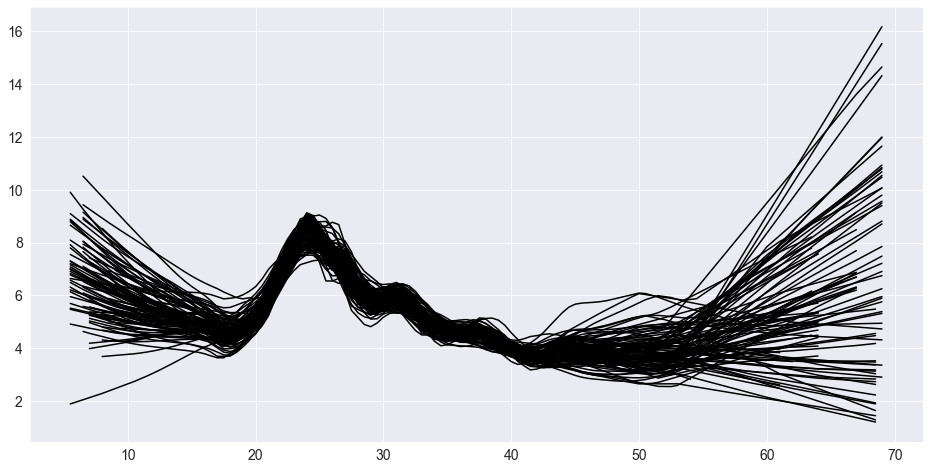

In [161]:
smoothed_data=[]
for i in range(100):
    d_sample = d.sample(frac=.3)
    smoothed = sm.nonparametric.lowess(exog=d_sample['v85'], endog=d_sample['prop'], frac=0.2)
    smoothed_data.append(smoothed)
    plt.plot(smoothed[:, 0], smoothed[:, 1], c="k")
